### ESTRATEGIA DE TRADE A TESTEAR: 

### Desarbitraje en la apertura de la rueda (30 minutos) entre el precio del CEDEAR y el precio de cierre de la acción del día anterior en plaza NY.


In [3]:
import yfinance as yf
import pandas as pd
import datetime as dt
from datetime import date, timedelta

#FUNCIONES DEFINIDAS:


#1) Necesito generar strings de fechas para la descarga de datos de yf (start,end)

def genera_fechas():
    hoy=dt.date.today()
    dia_ant = hoy - timedelta(days = 1)

    if dia_ant.weekday()==5:
        ayer=dia_ant- timedelta(days = 1)
    elif dia_ant.weekday()==6:
        ayer=dia_ant- timedelta(days = 2)
    else:
        ayer=dia_ant

    return hoy,ayer


#2) A partir del ticker ingresado por el usuario la siguiente función genera el ticker de la acción y del CEDEAR

def genera_tickers():
    NY=ticker
    BA=ticker+'.BA'
    
    return NY,BA


#3) Descargo los datos en t-1 de la acción plaza NY y del CEDEAR

def descarga_data_ayer():
    NY=yf.download(tickerNY,start=ayerString, end=hoyString,interval='1m')
    BA=yf.download(tickerBA,start=ayerString, end=hoyString,interval='1m')

    return NY,BA


#4) A partir de los datos de la jornada previa la siguiente función me calcula un CCL para cada minuto de la rueda

def ccl_ayer():
    df['CCL']=df[tickerBA]/df[tickerNY]/ratio_cedear()

    df['sma_20']=df['CCL'].rolling(20).mean()
    df['desvio'] = df['CCL'].rolling(20).std()

    return df.dropna()


#5) Descargo las cotizaciones del CEDEAR en la apertura de la rueda de "t" (30 minutos)

def descarga_data_hoy():
    startString = str(hoyString)+" 11:00:00"
    endString = str(hoyString)+" 11:30:00"

    print(startString)
    print(endString)

    dataTest=yf.download(tickerBA,period='7d',interval='1m')
    dfTest=dataTest.loc[startString:endString]
    dfTest=dfTest['Adj Close']
    
    return dfTest


#6) Cargo en una variable el precio de cierre de la acción plaza NY en t-1

def precio_cierre_NY():
    dataNY=yf.download(tickerNY,period='2d',interval='1d')
    cierreNY=dataNY.loc[ayerString]['Adj Close']
    return cierreNY


#7) Accede al listado de CEDEARS con sus respectivos ratios

def consultar_ratios():
    url='https://www.comafi.com.ar/2254-CEADEAR-SHARES.note.aspx'
    df=pd.read_html(url,thousands='.')
    return df[0]


#8) La siguiente función genera el ratio del CEDEAR

def ratio_cedear():
    ratios=consultar_ratios().set_index('Simbolo BYMA')
    ratio=list(ratios.loc[tickerNY]['Ratio of CEDEARs to Ords'])

    if len(ratio)>3:
        ratioCedear=int(ratio[-1])/(int(ratio[0]+ratio[1]))
    else:
        ratioCedear=int(ratio[-1])/(int(ratio[0]))
        
    return ratioCedear

In [4]:
# INGRESO DEL TICKER:

hoyString=str(genera_fechas()[0])
ayerString=str(genera_fechas()[1])

ticker=input('Ingrese el ticker de la acción: ')
genera_tickers()

tickerNY=genera_tickers()[0]
tickerBA=genera_tickers()[1]

# SELECCIONO LAS COLUMNAS CON LAS QUE VOY A TRABAJAR
pd.options.display.precision=4

preciosNY=descarga_data_ayer()[0]['Adj Close']
preciosBA=descarga_data_ayer()[1]['Adj Close']

df=pd.concat([preciosNY,preciosBA],join='outer',axis=1)
df.columns=[tickerNY,tickerBA]
df=df.dropna()
#df

# CALCULO UN PROXY PARA EL CCL QUE VOY A USAR PARA GENERAR LOS PRECIOS TEÓRICOS
# 2 metodologías: a) CCL promedio y b) última media movil calculada

ratio_cedear()

# a)
proxyCCL1=(ccl_ayer()['CCL'].sum())/ccl_ayer().shape[0]
print('CCL promedio: ', proxyCCL1)

# b)
ultimaFila=df.shape[0]-1
ultimoDato=df.index[ultimaFila]

proxyCCL2=df.loc[ultimoDato]['sma_20']
print('Ultima media movil: ', proxyCCL2)

#TESTEO DE LA IDEA DE TRADE

# Al dataFrame con las cotizaciones de la apertura del CEDEAR en "t" le agregamos las siguientes columnas: CCL, CCL2, Ratio, 
# Cierre_NY y Precio_teorico

dfTest=pd.DataFrame(descarga_data_hoy())
dfTest['CCL']=proxyCCL1
dfTest['CCL2']=proxyCCL2
dfTest['Ratio']=float(ratio_cedear())
dfTest['Cierre_NY']=precio_cierre_NY()
precioTeorico=(dfTest['Adj Close']/dfTest['Ratio']/dfTest['CCL2'])
dfTest['Precio_teorico']=precioTeorico

dfTest.loc[dfTest['Precio_teorico']>dfTest['Cierre_NY'],'Señal_Trade'] = 'Vender'
dfTest.loc[dfTest['Precio_teorico']==dfTest['Cierre_NY'],'Señal_Trade'] = 'Hold'
dfTest.loc[dfTest['Precio_teorico']<dfTest['Cierre_NY'],'Señal_Trade'] = 'Comprar'

dfTest

Ingrese el ticker de la acción: MSFT
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed
CCL promedio:  130.87289635122283
Ultima media movil:  131.72062675874832
2020-08-13 11:00:00
2020-08-13 11:30:00
[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


,Adj Close,CCL,CCL2,Ratio,Cierre_NY,Precio_teorico,Señal_Trade
Datetime,,,,,,,
2020-08-13 11:00:00-03:00,5550.0,130.8729,131.7206,0.2,209.19,210.6732,Vender
2020-08-13 11:01:00-03:00,5502.0,130.8729,131.7206,0.2,209.19,208.8511,Comprar
2020-08-13 11:02:00-03:00,5400.0,130.8729,131.7206,0.2,209.19,204.9793,Comprar
2020-08-13 11:03:00-03:00,5490.0,130.8729,131.7206,0.2,209.19,208.3956,Comprar
2020-08-13 11:04:00-03:00,5490.0,130.8729,131.7206,0.2,209.19,208.3956,Comprar
2020-08-13 11:07:00-03:00,5500.0,130.8729,131.7206,0.2,209.19,208.7752,Comprar
2020-08-13 11:09:00-03:00,5500.0,130.8729,131.7206,0.2,209.19,208.7752,Comprar
2020-08-13 11:10:00-03:00,5520.0,130.8729,131.7206,0.2,209.19,209.5344,Vender
2020-08-13 11:11:00-03:00,5520.0,130.8729,131.7206,0.2,209.19,209.5344,Vender


#### Grafíco la cotización del CEDEAR durante la primer media hora de la rueda vs. el precio de cierre de la acción plaza NY en t-1

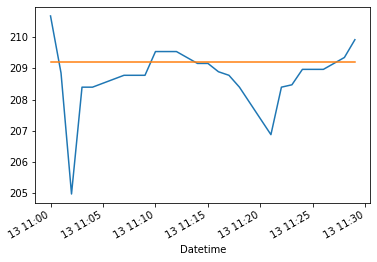

In [5]:
dfTest['Precio_teorico'].plot()
dfTest['Cierre_NY'].plot()

In [ ]:
#+IDEA: HACER UNA FUNCIÓN (FOR) QUE HAGA EL CÁLCULO PARA TODOS LOS CEDEARS Y ME DEVUELVA UNA MATRIZ DONDE SE DESTAQUEN
         #LOS MAS DESARBITRADOS

In [ ]:
#Mejora 1: que reconozca feriados!
#Mejora 2: Debería transformar las fechas a la misma zona horaria, antes de hacer el concat? Porque sino no se con que criterio 
#me está concatenando
#Mejora 3: incorporar al criterio de desición una condición sobre los desvios del CCL 